In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
import torchvision.models as models
import numpy as np
from elpv_dataset_master.utils.elpv_reader import load_dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import cv2
import seaborn as sns

In [ ]:
# Load the dataset
images, probs, types = load_dataset()

# Preprocess the images: Reshape and normalize
images = torch.tensor(images).view(-1, 1, 300, 300).float() / 255.0

label_classes = []
for p in range(len(probs)):
    if probs[p] == 0.0:
        label_classes.append(0)
    elif probs[p] == 0.3333333333333333:
        label_classes.append(1)
    elif probs[p] == 0.6666666666666666:
        label_classes.append(2)
    else:
        label_classes.append(3)

In [ ]:
# Convert probs to categorical labels for classification
probs_categorical = torch.tensor(label_classes).long()

train_images, test_images, train_probs, test_probs, train_types, test_types = train_test_split(images, probs_categorical,
                                                                                               types, test_size=0.25,
                                                                                               random_state=31)

# Convert to PyTorch datasets
train_dataset = TensorDataset(train_images, train_probs)
test_dataset = TensorDataset(test_images, test_probs)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
trainDataImages, mixedTestDataImages = train_test_split(images, test_size=0.25, shuffle=False)
trainDataProbs, mixedTestDataProbs = train_test_split(probs, test_size=0.25, shuffle=False)
trainDataTypes, mixedTestDataTypes = train_test_split(types, test_size=0.25, shuffle=False)

mono_test_images = []
mono_test_probs = []
poly_test_images = []
poly_test_probs = []

for i in range(len(test_types)):
    if test_types[i] == 'mono':
        mono_test_images.append(test_images[i])
        mono_test_probs.append(test_probs[i])
    else:
        poly_test_images.append(test_images[i])
        poly_test_probs.append(test_probs[i])

# Convert lists to PyTorch tensors
mono_test_images_tensor = torch.stack(mono_test_images)
mono_test_probs_tensor = torch.tensor(mono_test_probs)

poly_test_images_tensor = torch.stack(poly_test_images)
poly_test_probs_tensor = torch.tensor(poly_test_probs)

# Convert to PyTorch datasets
mono_test_dataset = TensorDataset(mono_test_images_tensor, mono_test_probs_tensor)
poly_test_dataset = TensorDataset(poly_test_images_tensor, poly_test_probs_tensor)

# Create data loaders
mono_test_loader = DataLoader(mono_test_dataset, batch_size=32, shuffle=False)
poly_test_loader = DataLoader(poly_test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet
efficientnet = models.efficientnet.efficientnet_b0(pretrained=False, num_classes=4)

# Modify the first convolutional layer for 1 channel input
first_conv_layer = efficientnet.features[0][0]
new_kernel_size = (3, 3)
efficientnet.features[0][0] = nn.Conv2d(in_channels=1,
                                        out_channels=first_conv_layer.out_channels,
                                        kernel_size=new_kernel_size,
                                        stride=first_conv_layer.stride,
                                        padding=first_conv_layer.padding,
                                        bias=False)

# Modify the classifier layer
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 4)

efficientnet = efficientnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet.parameters(), lr=0.01, momentum=0.9)

C:\Users\user\miniconda3\envs\newcuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\miniconda3\envs\newcuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
num_epochs = 50
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/50], Loss: 1.0911, Accuracy: 59.10%
Epoch [2/50], Loss: 1.0220, Accuracy: 63.87%
Epoch [3/50], Loss: 1.0223, Accuracy: 62.60%
Epoch [4/50], Loss: 0.9911, Accuracy: 63.36%
Epoch [5/50], Loss: 0.9714, Accuracy: 64.23%
Epoch [6/50], Loss: 0.9572, Accuracy: 64.63%
Epoch [7/50], Loss: 0.9260, Accuracy: 67.02%
Epoch [8/50], Loss: 0.8977, Accuracy: 67.94%
Epoch [9/50], Loss: 0.9048, Accuracy: 67.78%
Epoch [10/50], Loss: 0.8672, Accuracy: 68.75%
Epoch [11/50], Loss: 0.8498, Accuracy: 69.46%
Epoch [12/50], Loss: 0.8477, Accuracy: 69.31%
Epoch [13/50], Loss: 0.8438, Accuracy: 69.72%
Epoch [14/50], Loss: 0.8356, Accuracy: 70.58%
Epoch [15/50], Loss: 0.7972, Accuracy: 70.99%
Epoch [16/50], Loss: 0.7931, Accuracy: 70.58%
Epoch [17/50], Loss: 0.7894, Accuracy: 70.83%
Epoch [18/50], Loss: 0.7865, Accuracy: 71.09%
Epoch [19/50], Loss: 0.7673, Accuracy: 71.34%
Epoch [20/50], Loss: 0.7566, Accuracy: 72.61%
Epoch [21/50], Loss: 0.7341, Accuracy: 73.93%
Epoch [22/50], Loss: 0.7530, Accuracy: 72.4

In [ ]:
def evaluate_model(model, data_loader, device, title):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Accuracy: {accuracy*100:.2f} %')
    print(f'F1 Score: {f1*100:.2f} %')

    # Plotting Confusion Matrix using Seaborn
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

    print(classification_report(all_labels, all_preds))

    return accuracy, f1, conf_matrix

Accuracy: 71.49 %
F1 Score: 70.28 %


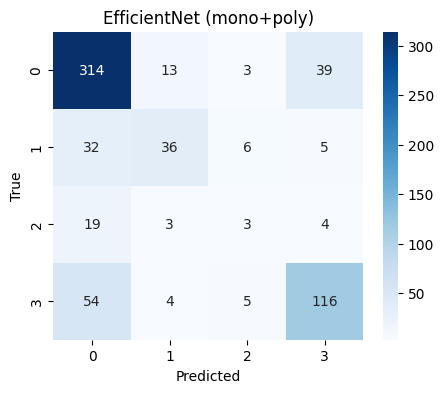

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       369
           1       0.64      0.46      0.53        79
           2       0.18      0.10      0.13        29
           3       0.71      0.65      0.68       179

    accuracy                           0.71       656
   macro avg       0.57      0.51      0.53       656
weighted avg       0.70      0.71      0.70       656



In [ ]:
accuracy, f1, conf_matrix = evaluate_model(efficientnet, test_loader, device,
                                           'EfficientNet (mono+poly)')

Accuracy: 71.70 %
F1 Score: 70.75 %


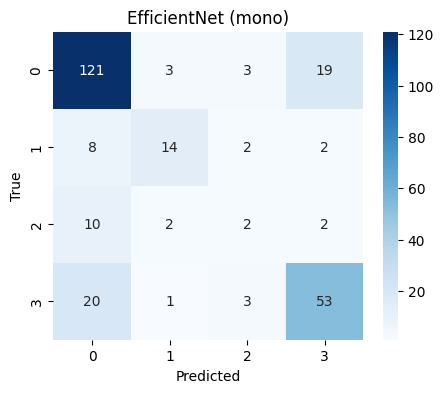

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       146
           1       0.70      0.54      0.61        26
           2       0.20      0.12      0.15        16
           3       0.70      0.69      0.69        77

    accuracy                           0.72       265
   macro avg       0.59      0.55      0.56       265
weighted avg       0.70      0.72      0.71       265



In [ ]:
mono_accuracy, mono_f1, mono_conf_matrix = evaluate_model(efficientnet, mono_test_loader, device,
                                                         'EfficientNet (mono)')

Accuracy: 71.36 %
F1 Score: 69.91 %


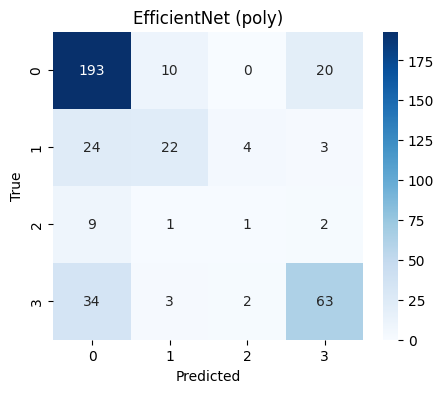

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       223
           1       0.61      0.42      0.49        53
           2       0.14      0.08      0.10        13
           3       0.72      0.62      0.66       102

    accuracy                           0.71       391
   macro avg       0.55      0.49      0.51       391
weighted avg       0.70      0.71      0.70       391



In [ ]:
poly_accuracy, poly_f1, poly_conf_matrix = evaluate_model(efficientnet, poly_test_loader, device,
                                                         'EfficientNet (poly)')

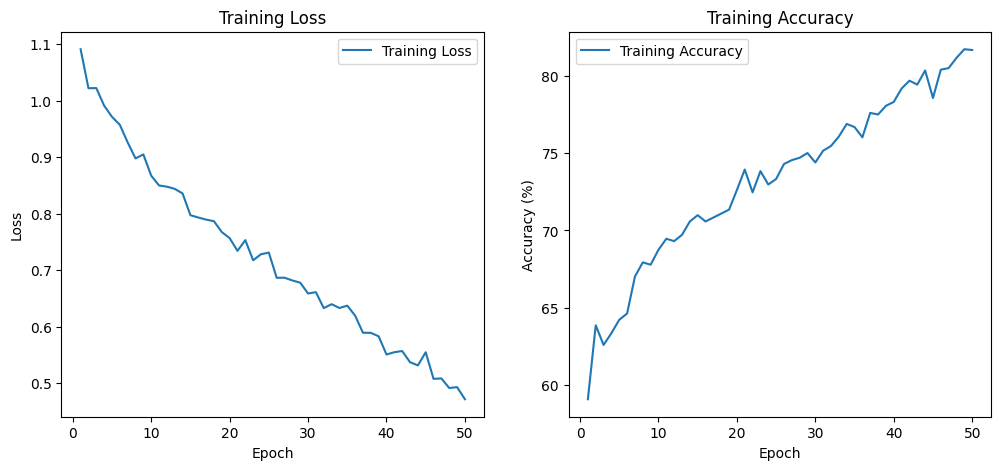

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.show()